Imports

In [1]:
import gym
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
from torch.distributions import Categorical
from torch.utils.data import TensorDataset, DataLoader

Our functions

In [ ]:
from Train_policy_func import Policy, load_policy
from Plot_Functions import plot_suboptimality, plot_trajectory_performance, plot_Scores, plot_suboptimality_three_policies, plot_scores_RLHF, plot_avg_loss_curves,plot_avg_reward_curves
from OPPO import baseline_Acrobot_v0, OPPO_update_Acrobot, set_seed
from PPO import evaluate_policy
from RLHF import RewardModel_Acro, train_policy_from_rollouts_n_updates_v2



In [3]:
class ShapedAcrobot(gym.Wrapper):
    def __init__(self, env, alpha=1.0, gamma=0.99):
        super().__init__(env)
        self.alpha, self.gamma = alpha, gamma
        self.last_pot = None

    def _potential(self, obs):
        c1, s1, c2, s2, a1, a2 = obs
        c12 = c1*c2 - s1*s2
        # normalized tip height in [–1,1]:
        return -(c1 + c12) / 2.0

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)
        self.last_pot = self._potential(obs)
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        # compute shaping term:
        pot = self._potential(obs)
        shaping = self.gamma * pot - self.last_pot
        shaped_reward = reward + self.alpha * shaping  #  -β*(θ̇1**2 + θ̇2**2)
        self.last_pot = pot
        return obs, shaped_reward, done, info




## Step 1:
Creating the policies of references, here for three different seeds.

The policies, for CartPole at least are optimised with an OPPO algorithm.
They are saved as "pi1\_ref\_{env_name}\_seed\_{seed}.pth" and "pi2\_ref\_{env_name}\_seed\_{seed}.pth"

For Pendulum, do not know.

In [4]:
env_name='Acrobot-v1-perso'
env = ShapedAcrobot(gym.make("Acrobot-v1"), alpha=1.0, gamma=0.99)
# env = gym.make(env_name)
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

baseline = baseline_Acrobot_v0 
target_score =  -150

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ── Hyperparams for OPPO ──
lr_oppo                 = 0.003
n_episodes              = 3000 # keep same “number of iterations” for fair comparison
max_t                   = 500  # cap on steps per episode
print_every             = 50   # print every x episodes and avg also the score for every x episodes
gamma                   = 0.99


load_policies   = True
evaluate_pi_ref = False
plot_scores     = False
n_eval          = 100

Policy_list     = []
seeds_list      = [35, 42, 100] 
# seeds_list      = [35] 

for seed in seeds_list:
    set_seed(seed, env)

    if load_policies:
        print(fr"Loading pi_1 and pi_2 with {seed=}")
        pi_1 = load_policy(f"./Policies/pi1_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)

    else:
        print(f"Training pi_1 and pi_2 with seed {seed}")

        pi_1 = Policy(state_size=obs_dim, action_size=action_dim).to(device)
        opt1 = torch.optim.Adam(pi_1.parameters(), lr=lr_oppo)


        scores_oppo = OPPO_update_Acrobot(
            policy          = pi_1,
            optimizer       = opt1,
            env             = env,
            baseline        = baseline,
            n_episodes      = n_episodes,
            max_t           = max_t,
            gamma           = gamma,      # you can reuse your PPO γ
            print_every     = print_every,
            early_stop      = False,
            seed            = seed,
            target_score    = target_score,
            env_name        = env_name,
            display_every   = False
        )


        pi_2 = load_policy(f"./Policies/pi2_ref_{env_name}_seed_{seed}.pth", obs_dim, action_dim, device)
    Policy_list.append([pi_1, pi_2])
    # print("------------------------------------------------------")

print("=================================")



Loading pi_1 and pi_2 with seed=35
Loading pi_1 and pi_2 with seed=42
Loading pi_1 and pi_2 with seed=100


C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\turin\OneDrive\EPFL\Master\MA2\RL\RLHF\Git RLHF\RL-RLHF\Train_policy_func.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://git

In [5]:
if evaluate_pi_ref:# ── Evaluate the policies ──
  print("Evaluating pi_1 and pi_2 for all seeds: \n")
  for seed, (pi_1, pi_2) in zip(seeds_list, Policy_list):
      
      print(f"Evaluating pi_1 and pi_2 with {seed=} over {n_eval} episodes")
      # Evaluate the policies
      seed_eval = seed+32
      _, pi1_rewards = evaluate_policy(pi_1, env, n_episodes=n_eval, seed=seed_eval)
      _, pi2_rewards = evaluate_policy(pi_2, env, n_episodes=n_eval, seed=seed_eval)
      print(f"Evaluations over {n_eval} episodes done for both policies, using the seed {seed}")
      print(f"\t pi_1({seed}) \t mean reward: \t {np.mean(pi1_rewards):.2f} ± {np.std(pi1_rewards):.2f}")
      print(f"\t pi_2({seed}) \t mean reward: \t {np.mean(pi2_rewards):.2f} ± {np.std(pi2_rewards):.2f}")

      if plot_scores:
          plot_Scores(
              pi1_rewards,
              pi2_rewards,
          )
      print("------------------------------------------------------")


  print("=================================")

### Now the Creation/loading of $\pi_{ref}^{1|2}$ is done
***
## We will implement the part RLHF

In [6]:
#Getting ride of potential 
env = gym.make("Acrobot-v1")

# PPO-RLHF hyperparameters
lr_PPO_RLHF          = 0.0003
n_ppo_updates        = 100      # number of PPO updates
# n_rollouts_ppo_rlhf  = 30       # number of rollouts to collect for the reward model; not used here
max_steps            = 2000      # max steps per episode
beta_ppo             = 10      # KL penalty coefficient
gamma_PPO            = 0.98
lambda_ppo           = 0.8 # 0.95
clip_eps             = 0.2
c1                   = 0.5         
c2                   = 0.01 # 0.1        
# rest of the parameters are the ones by default in PPO (see RLHF.py)


# Parameters for the RLHF part
# pair_list          = [20, 50, 200, 1000] # number of preference pairs to collect
load_RM              = True
load_rlhf_policies   = False
pi_ref_rlhf          = 1
load_pi2_start_rlhf  = False
plot_scores          = False
n_eval               = 100
compare_policies     = False
plot_learning_curves = True

pair_list          = [10, 50, 200, 1000] # number of preference pairs to collect

# Store the policies from PPO-RLHF learning
Policy_pporlhf_list  = []
Loss_history_list = []
reward_train_list=[]

for n_pair in pair_list:
    print(f"=============== using {n_pair=} ==================")
    # Pol_pair_rlhf     = []
    Pol_pair_PPO  = []
    loss_hist_1seed = []  
    reward_train_1seed=[]  

    for seed, (pi_1, pi_2) in zip(seeds_list, Policy_list):
        print(f"Seed {seed}")
        # Create the policy that will be trained with RLHF
        policy_PPO_RLHF = Policy(state_size= obs_dim, action_size= action_dim).to(device)

        if load_rlhf_policies:
            policy_PPO_RLHF = load_policy(fr"./Policies/pi_PPO_RLHF_{env_name}_seed_{seed}_beta{beta_ppo}_Npairs_{n_pair}.pth", obs_dim, action_dim, device)
            print(f"Loading policy trained with RLHF for {seed=}")
        else:
            # # -- Creating the preference pairs -- 
            # prefs = sample_preference_pairs(pi_1, pi_2, env, K=n_pairs)
            # torch.save(prefs, f"preference_pairs_PPO_{env_name}_seed_{seed}_Npairs_{n_pair}.pth")
            # print(f"Collected {n_pairs} preference pairs for {seed=}.")
            
            # -- Reward model -- 
            # Create the reward model
            print(f"Loading reward model trained on {n_pair} preference pairs")
            reward_model = RewardModel_Acro(state_dim=obs_dim, action_dim=action_dim).to(device)
            reward_model.load_state_dict(torch.load(fr"./Policies/reward_model_{env_name}_Npairs_{n_pair}.pth"))

            # -- Starting point of the policy --
            if load_pi2_start_rlhf: 
                # Starting point of the policy is pi_2
                policy_PPO_RLHF.load_state_dict(torch.load(fr"./Policies/pi2_ref_{env_name}_seed_{seed}.pth"))
            opt_PPO_RLHF    = torch.optim.Adam(policy_PPO_RLHF.parameters(), lr=lr_PPO_RLHF)

            # -- Training the new policy --
            policy_ref = pi_1 if pi_ref_rlhf == 1 else pi_2

            print(f"Training policy with PPO-RLHF using pi_{pi_ref_rlhf} as reference policy")
            loss_hist, rewards_across_training = train_policy_from_rollouts_n_updates_v2(policy_PPO_RLHF, policy_ref, reward_model, env, opt_PPO_RLHF, N=n_ppo_updates, max_steps=max_steps, beta=beta_ppo,gamma=gamma_PPO, lam=lambda_ppo, clip_eps=clip_eps, c1=c1, c2=c2)
            torch.save(policy_PPO_RLHF.state_dict(), fr"./Policies/pi_PPO_RLHF_{env_name}_seed_{seed}_beta{beta_ppo}_Npairs_{n_pair}.pth")
            print(fr"Saved final policy in ./Policies/pi_PPO_RLHF_{env_name}_seed_{seed}_beta{beta_ppo}_Npairs_{n_pair}.pth")
        
        Pol_pair_PPO.append(policy_PPO_RLHF)
        loss_hist_1seed.append(loss_hist)
        reward_train_1seed.append(rewards_across_training)
            
    Policy_pporlhf_list.append(Pol_pair_PPO)
    Loss_history_list.append(loss_hist_1seed)
    reward_train_list.append(reward_train_1seed)
torch.save(Loss_history_list, f"./Policies/LossCurve_PPO_{env_name}_Lastpair_{n_pair}.pth")
torch.save(reward_train_list, f"./Policies/rewardTraining_PPO_{env_name}_Lastpair_{n_pair}.pth")
print("=================================")


=============== using n_pair=10 ==================
Seed 35
Loading reward model trained on 10 preference pairs


C:\Users\turin\AppData\Local\Temp\ipykernel_54496\1542837747.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reward_model.load_state_dict(torch.load(fr"./Policies/rewar

Training policy with PPO-RLHF using pi_1 as reference policy


C:\Users\turin\AppData\Roaming\Python\Python311\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


[10/100] KL-divergence: 3.596676e-04  policy-loss: 1.099523e+00  loss=1.127271e+00 value-loss: 5.178996e-02  entropy: 1.742806e-01
[20/100] KL-divergence: 3.202161e-04  policy-loss: -5.965015e-02  loss=-5.195767e-02 value-loss: 1.704783e-02  entropy: 4.033590e-01
[30/100] KL-divergence: 7.962704e-04  policy-loss: 1.174806e+00  loss=1.281230e+00 value-loss: 2.094389e-01  entropy: 6.258264e-01
[40/100] KL-divergence: 5.605970e-04  policy-loss: -1.352828e-01  loss=-8.350714e-02 value-loss: 1.006989e-01  entropy: 4.179824e-01
[50/100] KL-divergence: 6.675888e-04  policy-loss: 5.695978e-01  loss=6.599459e-01 value-loss: 1.758800e-01  entropy: 4.267831e-01
[60/100] KL-divergence: 6.177973e-04  policy-loss: 1.656904e+00  loss=1.670632e+00 value-loss: 2.619938e-02  entropy: 5.549807e-01
[70/100] KL-divergence: 7.387380e-04  policy-loss: 3.851505e-01  loss=4.215289e-01 value-loss: 6.624722e-02  entropy: 4.132600e-01
[80/100] KL-divergence: 5.499513e-04  policy-loss: -1.426575e-01  loss=-9.37235

C:\Users\turin\AppData\Local\Temp\ipykernel_54496\1542837747.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reward_model.load_state_dict(torch.load(fr"./Policies/rewar

[10/100] KL-divergence: 1.889273e-03  policy-loss: 1.467573e-01  loss=2.233171e-01 value-loss: 1.313028e-01  entropy: 7.984392e-01
[20/100] KL-divergence: 1.332581e-03  policy-loss: -7.550181e-02  loss=-2.214344e-02 value-loss: 9.466757e-02  entropy: 7.301221e-01
[30/100] KL-divergence: 8.064045e-04  policy-loss: 3.934290e-01  loss=5.236586e-01 value-loss: 2.601042e-01  entropy: 7.886540e-01
[40/100] KL-divergence: 1.187920e-03  policy-loss: 6.980224e-01  loss=7.556188e-01 value-loss: 1.068723e-01  entropy: 7.718984e-01
[50/100] KL-divergence: 2.460229e-03  policy-loss: 2.662624e-01  loss=2.942198e-01 value-loss: 2.469763e-02  entropy: 8.993692e-01
[60/100] KL-divergence: 1.387371e-03  policy-loss: 5.524278e-01  loss=5.814272e-01 value-loss: 4.696430e-02  entropy: 8.356485e-01
[70/100] KL-divergence: 4.403510e-03  policy-loss: 8.851988e-01  loss=9.964516e-01 value-loss: 1.504434e-01  entropy: 8.004022e-01
[80/100] KL-divergence: 2.005627e-04  policy-loss: -1.081289e-01  loss=-8.069097e

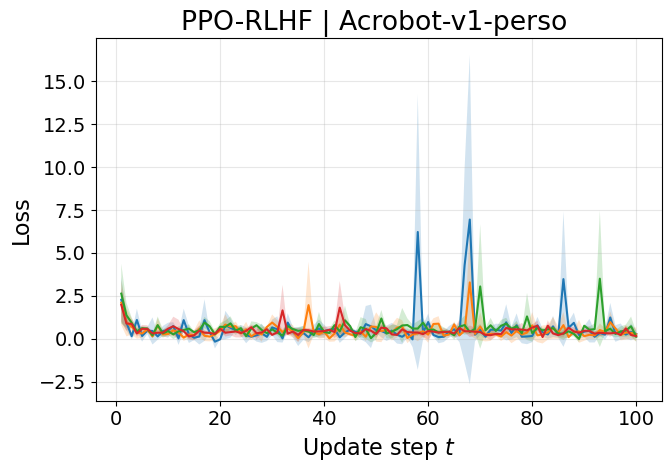

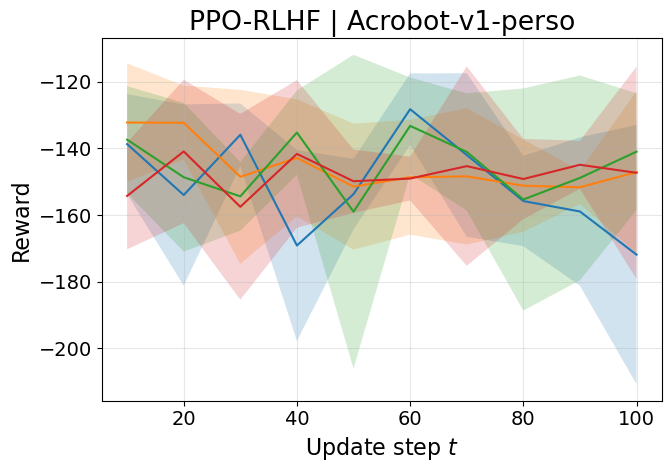

In [7]:
# ── Plotting the loss curves ──
plot_avg_loss_curves(
    loss_hist_list=Loss_history_list, 
    pair_list=pair_list, 
    algo="PPO-RLHF",
    legend=False,
    save=True,
    env_name=env_name,
)
plot_avg_reward_curves(reward_train_list,pair_list,algo="PPO-RLHF", legend=False, save=True, env_name=env_name)

***
## PPO-RLHF:

Evaluating pi_RLHF and pi_PPO_RLHF for all seeds and dataset size over 100 Runs 

=============== using n_pair=10 ==================
------------------------------------------------------
=============== using n_pair=50 ==================
------------------------------------------------------
=============== using n_pair=200 ==================
------------------------------------------------------
=============== using n_pair=1000 ==================
------------------------------------------------------


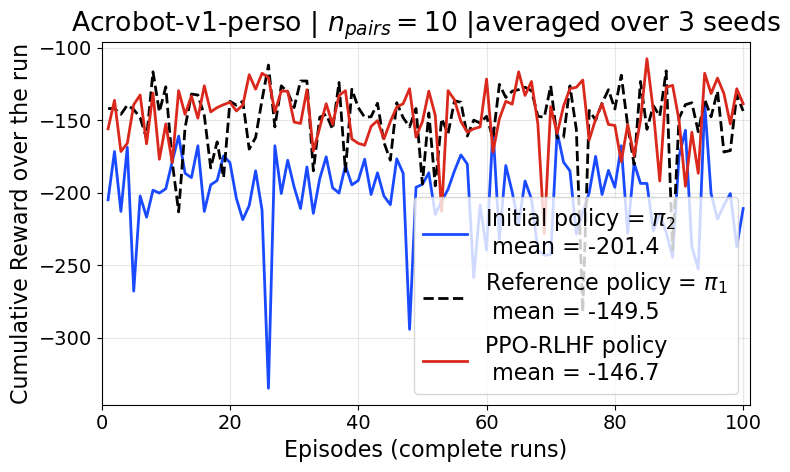

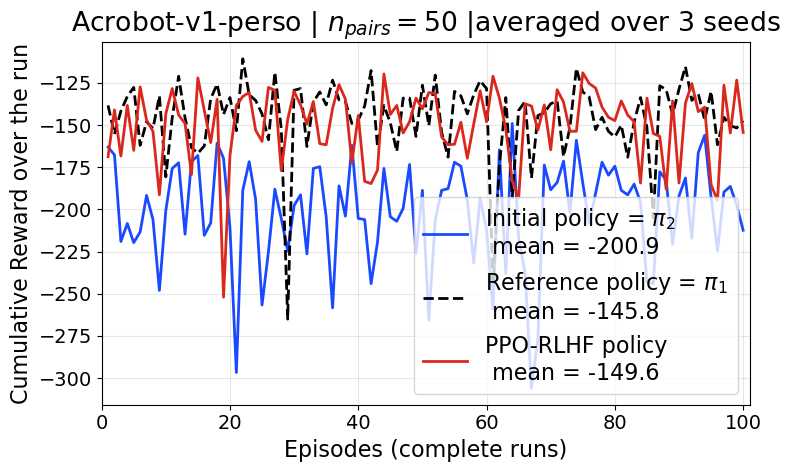

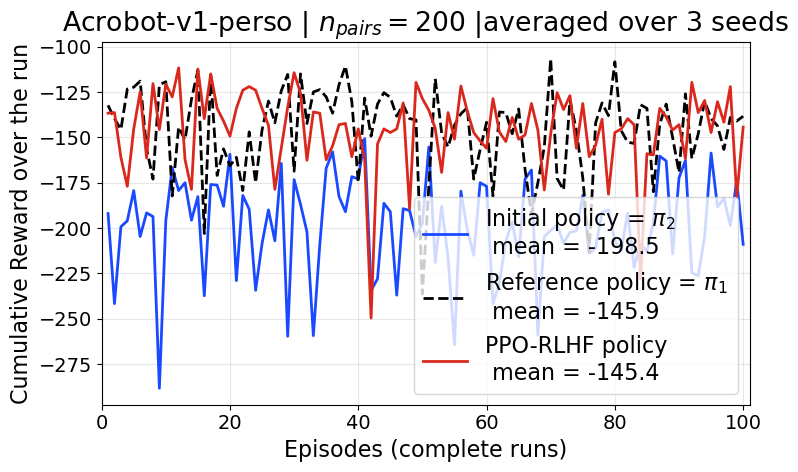

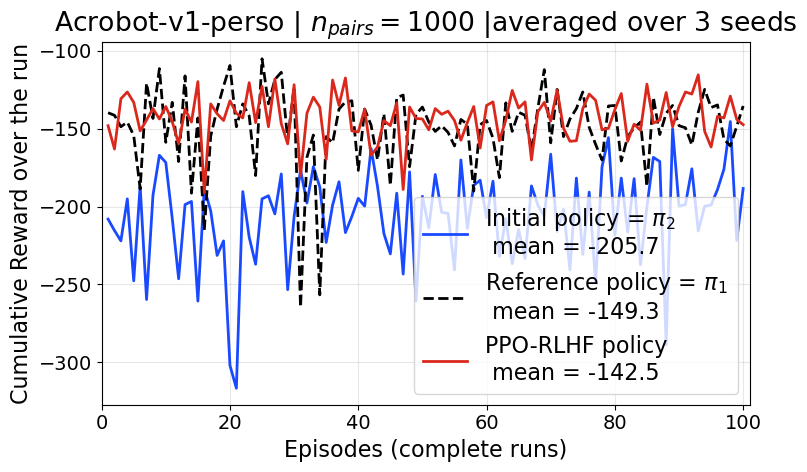

In [10]:
print(f"Evaluating pi_RLHF and pi_PPO_RLHF for all seeds and dataset size over {n_eval} Runs \n")
plot_scores = True

for i, n_pair in enumerate(pair_list):
    print(f"=============== using {n_pair=} ==================")    
    R_ref = 0
    R_init = 0
    R_ppo_rlhf = 0
    
    for seed, (pi_1, pi_2), pi_ppo_rlhf in zip(seeds_list, Policy_list, Policy_pporlhf_list[i]):
        seed_eval = seed+34
        _, pi1_rewards          = evaluate_policy(pi_1,     env, n_episodes=n_eval, seed=seed_eval)
        _, pi2_rewards          = evaluate_policy(pi_2,     env, n_episodes=n_eval, seed=seed_eval)
        _, pi_ppo_rlhf_rewards  = evaluate_policy(pi_ppo_rlhf, env, n_episodes=n_eval, seed=seed_eval)
        # _, pi_rlhf_rewards      = evaluate_policy(pi_rlhf,  env, n_episodes=n_eval, seed=seed_eval)

        # print(pi1_rewards, np.mean(pi1_rewards), np.std(pi1_rewards))
        R_ref       += np.array(pi1_rewards)/len(seeds_list)
        R_init      += np.array(pi2_rewards)/len(seeds_list)
        R_ppo_rlhf  += np.array(pi_ppo_rlhf_rewards)/len(seeds_list)
        
    if compare_policies:
        print(f"Evaluations over {n_eval} episodes done for the 3 policies, averaged over the 3 seeds for {n_pair=}")
        print(f"pi_1({n_pair})        \t mean reward: \t {np.mean(R_ref):.2f} ± {np.std(R_ref):.2f}")
        print(f"pi_2({n_pair})        \t mean reward: \t {np.mean(R_init):.2f} ± {np.std(R_init):.2f}")
        # print(f"pi_RLHF({seed})     \t mean reward: \t {np.mean(pi_rlhf_rewards):.2f} ± {np.std(pi_rlhf_rewards):.2f}")
        print(f"pi_PPO_RLHF({n_pair}) \t mean reward: \t {np.mean(R_ppo_rlhf):.2f} ± {np.std(R_ppo_rlhf):.2f}")
    if plot_scores:
        plot_scores_RLHF(R_init, R_ref, R_ppo_rlhf, algo="PPO-RLHF", save=True, n_pair=n_pair, env_name=env_name)

        print("------------------------------------------------------")

